# Appentissage profond pour le texte.
# Rendu 1 : Sentiment Analysis

In [ ]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import time

In [ ]:
from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import OneHotEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, f1_score

In [ ]:
import nltk
nltk.download("punkt")
from nltk import word_tokenize          
from nltk import FreqDist

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, TextVectorization
from tensorflow.keras.callbacks import EarlyStopping

## Dataset Loading

### Load The dataset

In [ ]:
TRAIN = pd.read_csv("http://www.i3s.unice.fr/~riveill/dataset/Amazon_Unlocked_Mobile/train.csv.gz")
VAL = pd.read_csv("http://www.i3s.unice.fr/~riveill/dataset/Amazon_Unlocked_Mobile/val.csv.gz")
TEST = pd.read_csv("http://www.i3s.unice.fr/~riveill/dataset/Amazon_Unlocked_Mobile/test.csv.gz")

TRAIN.head()

,Product Name,Brand Name,Price,Rating,Reviews,Review Votes
0,Samsung Galaxy Note 4 N910C Unlocked Cellphone...,Samsung,449.99,4,I love it!!! I absolutely love it!! 👌👍,0.0
1,BLU Energy X Plus Smartphone - With 4000 mAh S...,BLU,139.00,5,I love the BLU phones! This is my second one t...,4.0
2,Apple iPhone 6 128GB Silver AT&T,Apple,599.95,5,Great phone,1.0
3,BLU Advance 4.0L Unlocked Smartphone -US GSM -...,BLU,51.99,4,Very happy with the performance. The apps work...,2.0
4,Huawei P8 Lite US Version- 5 Unlocked Android ...,Huawei,198.99,5,Easy to use great price,0.0


### Understand the dataset

In [ ]:
# Tokenized the reviews
reviews_tokenized = [word_tokenize(review) for review in TRAIN['Reviews']]
reviews_tokenized[:10]

In [ ]:
# Count the vocabulary
flatten_reviews = [item for sublist in reviews_tokenized for item in sublist]
vocabulary_size = len(set(flatten_reviews))
vocabulary_size

13099

[('.', 10867), ('the', 8323), ('I', 6743), (',', 6551), ('and', 5429), ('it', 5217), ('phone', 5132), ('a', 4855), ('to', 4682), ('is', 3991)]


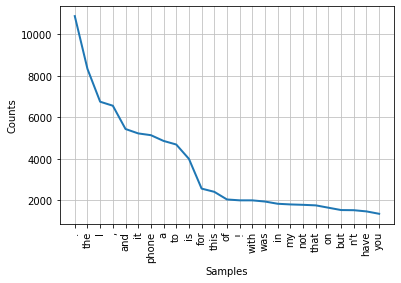

In [ ]:
# Plot the distribution of words
from nltk import FreqDist

freqDist = FreqDist(flatten_reviews)
print(freqDist.most_common(10))
freqDist.plot(25, cumulative=False)

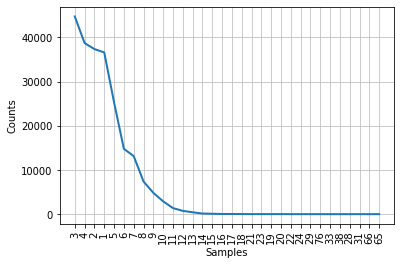

In [ ]:
# Plot the distibution of word length size
len_words = [len(w) for w in flatten_reviews]
freqDist2 = FreqDist(len_words)
freqDist2.plot(cumulative=False)

In [ ]:
# On TRAIN only because we don't know future data

# Add a column to the dataframe with the length in tokens of the review
TRAIN['length'] = [len(r) for r in reviews_tokenized]

# What is the maximum length of a review
print("MAX:", TRAIN['length'].max())

# What is the average length of a review
print("MEAN:", TRAIN['length'].mean())

# What is the length of a review so that 90% of it is under
print("90%:", TRAIN['length'].quantile(0.9))

MAX: 1137
MEAN: 45.7284
90%: 109.0


In [ ]:
# Put all reviews in lower case
lower_reviews = [r.lower() for r in TRAIN['Reviews']]
lower_reviews[:10]

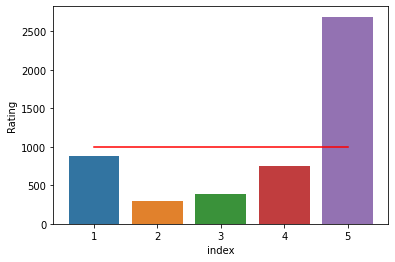

In [ ]:
# Is the dataset is balanced ?
data=pd.DataFrame(y_train)['Rating'].value_counts().reset_index()
sns.barplot(x="index", y="Rating", data=data)

y=len(y_train)/5
data=pd.DataFrame({"index":[0,4],"Rating":[y,y]})
sns.lineplot(x="index", y="Rating", data=data, color="red")

## Build X (features vectors) and y (labels)

In [ ]:
# Construct X_train and y_train
X_train = TRAIN['Reviews'].fillna("")
y_train = TRAIN['Rating']
X_train.shape, y_train.shape

((5000,), (5000,))

In [ ]:
# Construct X_val and y_val
X_val = VAL['Reviews'].fillna("")
y_val = VAL['Rating']
X_val.shape, y_val.shape

((1000,), (1000,))

In [ ]:
# Construct X_test and y_test
X_test = TEST['Reviews'].fillna("")
y_test = TEST['Rating']
X_test.shape, y_test.shape

((1000,), (1000,))

## Preprocessing

In [ ]:
# Encode dataset with CountVectorizer (X) and 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import OneHotEncoder

cv = CountVectorizer()
X_train_encoded = cv.fit_transform(X_train).toarray()
X_val_encoded = cv.transform(X_val).toarray()
X_test_encoded = cv.transform(X_test).toarray()

ohe = OneHotEncoder()
ohe.fit(np.array([1,2,3,4,5]).reshape(-1, 1))
y_train_encoded = ohe.transform(np.array(y_train).reshape(-1, 1)).toarray()
y_test_encoded = ohe.transform(np.array(y_test).reshape(-1, 1)).toarray()
y_val_encoded = ohe.transform(np.array(y_val).reshape(-1, 1)).toarray()

X_train_encoded.shape

(5000, 8991)

In [ ]:
# Initialize f1_score results dictionary
f1_scores = {}

## BOW + Logistic Regression

In [ ]:
# Define the pipeline
lr_pipeline = Pipeline([
        ('feature_extraction',  CountVectorizer()),
        ('classification',  LogisticRegression(multi_class='auto', max_iter=400))
        ])

# I fit the model
lr_pipeline.fit(X_train, y_train)

# I evaluate the model
y_pred = lr_pipeline.predict(X_test)

print(classification_report(y_pred, y_test))

f1_scores['bow-lr'] = f1_score(y_test, y_pred, average='weighted')

              precision    recall  f1-score   support

           1       0.62      0.64      0.63       155
           2       0.18      0.29      0.22        31
           3       0.17      0.23      0.20        52
           4       0.25      0.44      0.32        94
           5       0.91      0.76      0.83       668

    accuracy                           0.67      1000
   macro avg       0.43      0.47      0.44      1000
weighted avg       0.74      0.67      0.70      1000



## BOW + MLP

In [ ]:
# !pip install tensorflow-addons

In [ ]:
from tensorflow_addons.metrics import F1Score

nb_classes = 5 # number of classes to predict

f1_metric = F1Score(num_classes=nb_classes, threshold=0.5, average='weighted')

In [ ]:
# Configure the model and start training
# Stop training with early stopping with patience of 20
callbacks_list = [EarlyStopping(monitor='val_f1_score', min_delta=0.0005, 
                                patience=20, verbose=1, mode='max', 
                                restore_best_weights=True)]

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Activation

model = Sequential()
model.add(Dense(256, activation='relu'))
model.add(Dense(5, activation='softmax'))
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=[f1_metric])

In [ ]:
model.fit(X_train_encoded, y_train_encoded,
                    validation_data=(X_val_encoded, y_val_encoded),
                    epochs=1000, batch_size=250,
                    callbacks=callbacks_list, verbose=1)

In [ ]:
# Evaluate the model
y_pred_encoded = model.predict(X_test_encoded)
y_pred = np.argmax(y_pred_encoded,axis=1) + 1

print(classification_report(y_test, y_pred))

f1_scores['bow-mlp'] = f1_score(y_pred, y_test, average='weighted')

              precision    recall  f1-score   support

           1       0.66      0.60      0.63       159
           2       0.30      0.24      0.26        51
           3       0.25      0.21      0.23        71
           4       0.40      0.26      0.31       163
           5       0.77      0.90      0.83       556

    accuracy                           0.66      1000
   macro avg       0.48      0.44      0.45      1000
weighted avg       0.63      0.66      0.64      1000



## Keras embedding + MLP

In [ ]:
vocab_size = 500 # fix your vocabulary size
max_len = 32   # Sequence length to pad the outputs to.
                # In order to fix it, you have to know the distribution on lengh... see first lab
embed_dim = 100 # embedding dimension

vectorize_layer = TextVectorization(max_tokens=vocab_size,
  output_mode='int',
  output_sequence_length=max_len)

vectorize_layer.adapt(X_train)

In [ ]:
from tensorflow.keras.layers import Input, Dense, TextVectorization, Flatten, Embedding

input_ = Input(shape=(1, ), name="input", dtype=tf.string)
x = vectorize_layer(input_)
x = Embedding(vocab_size, embed_dim, name="Embedding")(x)
x = Flatten()(x)
x = Dense(128, activation="sigmoid", name="hidden1")(x)
output_ = Dense(nb_classes, activation='softmax', name="output")(x)
model = Model(input_, output_)
model.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 32)               0         
 torization)                                                     
                                                                 
 Embedding (Embedding)       (None, 32, 100)           50000     
                                                                 
 flatten_8 (Flatten)         (None, 3200)              0         
                                                                 
 hidden1 (Dense)             (None, 128)               409728    
                                                                 
 output (Dense)              (None, 5)                 645       
                                                           

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[f1_metric])
model.fit(X_train, y_train_encoded - np.min(y_train_encoded),
                    validation_data=(X_val, y_val_encoded - np.min(y_val_encoded)),
                    epochs=1000, batch_size=250,
                    callbacks=callbacks_list, verbose=1)

In [ ]:
# Evaluate the model
y_pred_encoded = model.predict(X_test)
y_pred = np.argmax(y_pred_encoded,axis=1) + 1

print(classification_report(y_test, y_pred))

f1_scores['emb-mlp'] = f1_score(y_pred, y_test, average='micro')

              precision    recall  f1-score   support

           1       0.56      0.57      0.56       159
           2       0.10      0.06      0.07        51
           3       0.22      0.15      0.18        71
           4       0.37      0.23      0.28       163
           5       0.73      0.86      0.79       556

    accuracy                           0.62      1000
   macro avg       0.39      0.37      0.38      1000
weighted avg       0.57      0.62      0.59      1000



## Word2vec + MLP

In [ ]:
# Build word dict
voc = vectorize_layer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

In [ ]:
# Download the pre-trained embeddin matrix for exemple from glove
# !wget http://nlp.stanford.edu/data/glove.6B.zip
# !unzip -q glove.6B.zip

In [ ]:
# Make a dict mapping words (strings) to their NumPy vector representation:
path_to_glove_file = "glove.6B.100d.txt"

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print(f"Found {len(embeddings_index)} word vectors.")

Found 400000 word vectors.


In [ ]:
num_tokens = len(voc) + 2
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embed_dim))
for word, i in word_index.items():
    # print(word, i)
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 497 words (3 misses)


In [ ]:
# Initialize the Embedding layer with the weight of each word
embedding_layer = Embedding(
    num_tokens,
    embed_dim,
    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
    trainable=False,
)
num_tokens, embed_dim, max_len

(502, 100, 32)

In [ ]:
input_ = Input(shape=(1, ), name="input", dtype=tf.string)
x = vectorize_layer(input_)
x = embedding_layer(x)
x = Flatten()(x)
x = Dense(256, activation="relu", name="hidden")(x)
output_ = Dense(nb_classes, activation='softmax', name="output")(x)
model = Model(input_, output_)
model.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 32)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 32, 100)           50200     
                                                                 
 flatten_9 (Flatten)         (None, 3200)              0         
                                                                 
 hidden (Dense)              (None, 256)               819456    
                                                                 
 output (Dense)              (None, 5)                 1285      
                                                           

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[f1_metric])
model.fit(X_train, y_train_encoded - np.min(y_train_encoded),
                    validation_data=(X_val, y_val_encoded - np.min(y_val_encoded)),
                    epochs=1000, batch_size=250,
                    callbacks=callbacks_list, verbose=1)

In [ ]:
# Evaluate the model
y_pred_encoded = model.predict(X_test)
y_pred = np.argmax(y_pred_encoded,axis=1) + 1

print(classification_report(y_test, y_pred))

f1_scores['v2w-mlp'] = f1_score(y_pred, y_test, average='micro')

              precision    recall  f1-score   support

           1       0.45      0.47      0.46       159
           2       0.19      0.10      0.13        51
           3       0.10      0.07      0.08        71
           4       0.28      0.21      0.24       163
           5       0.71      0.81      0.76       556

    accuracy                           0.57      1000
   macro avg       0.35      0.33      0.34      1000
weighted avg       0.53      0.57      0.55      1000



## Embedding au choix + RNN

### Affichage des résultats

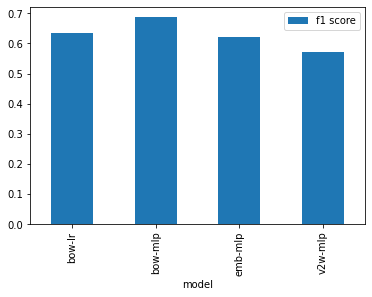

In [ ]:
df = pd.DataFrame({"model":[i for i in f1_scores.keys()], "f1 score":[i for i in f1_scores.values()]})
df.plot(x="model", y="f1 score", kind="bar")